In [37]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

Проверим модели библиотеки OpenCV для распознования лиц, определения "размеров" (bounding box) и определения очков

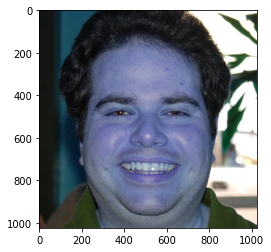

In [43]:
img_test = 'test/02826.jpg'
image = cv2.imread(img_test)
plt.imshow(image)

In [44]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

### Распознование лица и его bounding box'а

Лиц обнаружено: 1


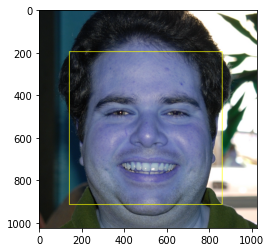

In [45]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(
    gray,
    scaleFactor= 1.1,
    minNeighbors= 5,
    minSize=(10, 10)
)
faces_detected = "Лиц обнаружено: " + format(len(faces))
print(faces_detected)
# Рисуем квадраты вокруг лиц
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 255, 0), 2)
    roi_gray = gray[y:y+h, x:x+w]
plt.imshow(image)

### Распознование очков

Очков обнаружено: 1


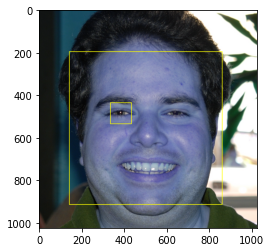

In [46]:
glasses_cascade = cv2.CascadeClassifier('haarcascade_eye_tree_eyeglasses.xml')
glasses = glasses_cascade.detectMultiScale(
    cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),
    scaleFactor= 1.1,
    minNeighbors= 20,
    minSize=(10, 10)
)
glasses_detected = "Очков обнаружено: " + format(len(glasses))
print(glasses_detected)
# Рисуем квадраты вокруг лиц
for (x, y, w, h) in glasses:
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 255, 0), 2)
plt.imshow(image)

Для детектирования очков выдается ложно положительный результат, попробуем воспользоваться нейронной сетью из https://www.kaggle.com/jorgebuenoperez/computer-vision-application-of-cnn/notebook

### Нейронная сеть

Подключим модель и зададим размеры для преобразования картинки

In [42]:
model_nn = keras.models.load_model('best_model')
IMG_SIZE = (160, 160)

Преобразуем картинки в jpg и в соответствующий размер. <br>
Картинки берем отсюда https://github.com/NVlabs/ffhq-dataset

In [9]:
file_to_predict = []
for (dirpath, dirnames, filenames) in os.walk('test'):
    for f in filenames:
        img_src = dirpath+'/'+f
        image = cv2.imread(img_src)
        img_jpg_src = dirpath+'/'+f.replace('png', 'jpg')
        file_to_predict.append(img_jpg_src)
        cv2.imwrite(img_jpg_src, image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

Функции для детектирования очков и определения лиц на фото

In [31]:
def hasGlasses(f, prob=.5):
    """Детектирование очков
    f    - путь к изображению
    prob - вероятность при которой будем определять, есть ли на фото очки
    """
    # преобразование изображения
    img = tf.keras.preprocessing.image.load_img(f, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = tf.keras.applications.resnet50.preprocess_input(img_batch)
    prediction = model_nn.predict(img_preprocessed)
    prediction = tf.nn.sigmoid(prediction)
    # предсказание
    prediction = tf.where(prediction > prob, 0, 1)
    return bool(prediction[0])

In [11]:
def checkSizeFaces(image):
    """Поиск лиц
    image - объект изображения
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor= 1.1,
        minNeighbors= 5,
        minSize=(10, 10)
    )
    # если лиц нет или больше одного, то фото не подходит
    if len(faces) != 1:
        return False
    
    # Определяем размеры лица по bounded box
    x, y, w, h = faces[0]
    return (w >= 256) and (h >= 256)

Отбираем фото по нужным параметрам

In [28]:
for f in file_to_predict:
    img_f = cv2.imread(f)
    has_glasses = hasGlasses(f)
    correct_size_face = checkSizeFaces(img_f)
    if has_glasses and correct_size_face:
        res_path = f.replace('test', 'result')
        cv2.imwrite(res_path, img_f, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

В результате получились картинки, на которых люди без очков. <br>
Попробуем из этих картинок еще раз сделать отбор, но с при вероятности детектирования 99% 

In [33]:
# Считываем новые файлы
file_to_predict = []
for (dirpath, dirnames, filenames) in os.walk('result'):
    for f in filenames:
        img_jpg_src = dirpath+'/'+f
        file_to_predict.append(img_jpg_src)
file_to_predict[:5]

['result/01001.jpg',
 'result/01009.jpg',
 'result/01010.jpg',
 'result/01012.jpg',
 'result/01014.jpg']

In [36]:
# Проводим новый отбор
for f in file_to_predict:
    img_f = cv2.imread(f)
    has_glasses = hasGlasses(f, .99)
    correct_size_face = checkSizeFaces(img_f)
    
    if has_glasses and correct_size_face:
        res_path = f.replace('result', 'result2')
        cv2.imwrite(res_path, img_f, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

Не сильно помогло, возможно стоит поднять порог еще или переобучить модель

### Вывод
- Модель распознавания лиц OpenCV плохо выявляет частично скрытые лица
- Модель детектирования очков тоже плохо работает